In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import scrublet as scr
import os
import warnings
import functools
import seaborn as sns
import scipy.stats
import anndata
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

warnings.filterwarnings('ignore')
os.chdir(os.path.expanduser('/home/jovyan/Prostate_analysis/scanpy'))
sc.settings.verbosity = 3
sc.logging.print_versions()

results_file = 'out/mnp.integrated.h5ad'

adata = sc.read_h5ad(results_file)
adata

/home/jovyan/my-conda-envs/mypython3/lib/python3.7/site-packages/dask/config.py:161: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


scanpy==1.4.5.post2 anndata==0.6.22.post1 umap==0.3.10 numpy==1.17.2 scipy==1.4.1 pandas==0.25.1 scikit-learn==0.22.1 statsmodels==0.11.0rc1 python-igraph==0.7.1 louvain==0.6.1


AnnData object with n_obs × n_vars = 793 × 3000 
    obs: 'age', 'barcode', 'batch', 'group', 'highest_GLEASON_score', 'mri_grading', 'name', 'patient', 'pool', 'psa', 'sample', 'scrublet_score', 'scrublet_cluster_score', 'bh_pval', 'is_doublet', 'n_genes', 'percent_mito', 'n_counts', 'S_score', 'G2M_score', 'phase', 'leiden', 'celltype', 'cohort', 'nCount_RNA', 'nFeature_RNA', 'nCount_SCT', 'nFeature_SCT', 'celltype-immune'
    var: 'gene_ids', 'feature_types'
    uns: 'celltype-immune_colors', 'cohort_colors', 'dendrogram_celltype-immune', 'dendrogram_leiden', 'group_colors', 'leiden', 'leiden_colors', 'neighbors', 'patient_colors', 'pca', 'phase_colors', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'

In [2]:
adata = adata[adata.obs['celltype-immune'] == 'Mac-MT1']
adata

View of AnnData object with n_obs × n_vars = 52 × 3000 
    obs: 'age', 'barcode', 'batch', 'group', 'highest_GLEASON_score', 'mri_grading', 'name', 'patient', 'pool', 'psa', 'sample', 'scrublet_score', 'scrublet_cluster_score', 'bh_pval', 'is_doublet', 'n_genes', 'percent_mito', 'n_counts', 'S_score', 'G2M_score', 'phase', 'leiden', 'celltype', 'cohort', 'nCount_RNA', 'nFeature_RNA', 'nCount_SCT', 'nFeature_SCT', 'celltype-immune'
    var: 'gene_ids', 'feature_types'
    uns: 'celltype-immune_colors', 'cohort_colors', 'dendrogram_celltype-immune', 'dendrogram_leiden', 'group_colors', 'leiden', 'leiden_colors', 'neighbors', 'patient_colors', 'pca', 'phase_colors', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'

In [3]:
# extract the genes into two new object
adat = sc.AnnData(adata.raw.X, obs = adata.obs, var = adata.raw.var, obsm = adata.obsm)
adat

AnnData object with n_obs × n_vars = 52 × 10357 
    obs: 'age', 'barcode', 'batch', 'group', 'highest_GLEASON_score', 'mri_grading', 'name', 'patient', 'pool', 'psa', 'sample', 'scrublet_score', 'scrublet_cluster_score', 'bh_pval', 'is_doublet', 'n_genes', 'percent_mito', 'n_counts', 'S_score', 'G2M_score', 'phase', 'leiden', 'celltype', 'cohort', 'nCount_RNA', 'nFeature_RNA', 'nCount_SCT', 'nFeature_SCT', 'celltype-immune'
    var: 'gene_ids', 'feature_types'
    obsm: 'X_pca', 'X_umap'

In [40]:
class_vector = adat.obs['group']
gene_exp = pd.DataFrame(adat.X.toarray(), columns = adat.var.index, index = adat.obs.index).transpose()
gene_exp.reset_index(drop = False, inplace = True)

In [41]:
import gseapy as gp
res = gp.gsea(data=gene_exp,
              gene_sets='dataset/Macrophage_stim_markers_Human.gmt',
              cls=list(class_vector),
              permutation_type='phenotype',
              permutation_num=1000, # reduce number to speed up testing
              outdir=None,  # do not write output to disk
              no_plot=True, # Skip plotting
              method='signal_to_noise',
              processes=20,
              min_size=0,
              max_size=1000,
              verbose=True)

2020-03-23 22:45:14,825 Parsing data files for GSEA.............................
2020-03-23 22:45:14,941 0000 gene_sets have been filtered out when max_size=1000 and min_size=0
2020-03-23 22:45:14,943 0028 gene_sets used for further statistical testing.....
2020-03-23 22:45:14,944 Start to run GSEA...Might take a while..................
2020-03-23 22:45:15,863 Start to generate GSEApy reports and figures............
2020-03-23 22:45:15,876 Congratulations. GSEApy ran successfully.................



In [44]:
res.res2d.to_csv('out/GSEA/Mac-MT1_macstim_gsea_tumor_vs_normal_full.txt', sep ='\t')

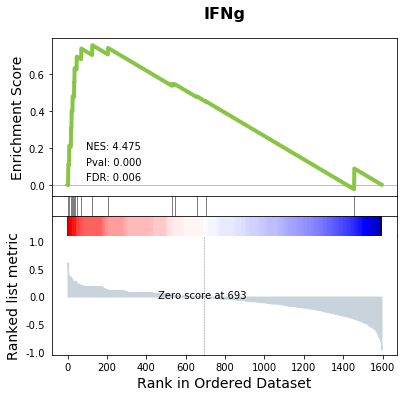

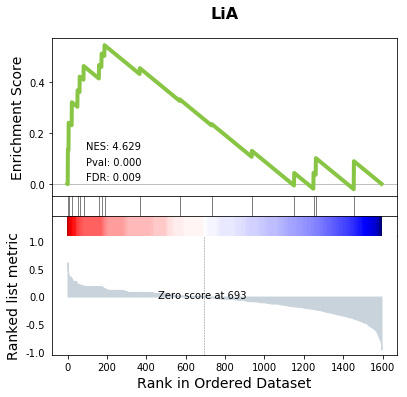

In [57]:
from gseapy.plot import gseaplot, heatmap
terms = res.res2d.index
# Make sure that ``ofname`` is not None, if you want to save your figure to disk
gseaplot(res.ranking, term=terms[0], **res.results[terms[0]])
gseaplot(res.ranking, term=terms[1], **res.results[terms[1]])

In [59]:
### run GSEA on the tumor vs normal on Mac-MT1 for just the Hallmark metabolism genes
def rankList(deg_file, remove_ribo_mito = False):
    # read in the files and do some ranking calculations
    deg = pd.read_csv(deg_file, sep = '\t', index_col = 0)
    if remove_ribo_mito:
        # remove ribosomal and mitochondrial genes
        deg = deg[~deg.index.str.contains('RPS|RPL|MT-')]

    # convert to negative log10 pval
    deg['neglog10pval'] = [-1*np.log10(p) for p in deg['pvals']]
    # convert inf values to max machine number
    try:
        deg['neglog10pval'].replace(np.inf, -1*np.log10(10**-308), inplace = True)
    except:
        pass
    try:    
        deg['neglog10pval'].replace(-np.inf, -1*np.log10(10**308), inplace = True)
    except:
        pass
    deg['rank'] = [p*np.sign(lfc) for p, lfc in zip(deg['neglog10pval'], deg['logfoldchanges'])]
    deg = deg.reset_index(drop = False)
    return(deg[['index', 'rank']])
# quickly prep the files
MacMT1 = rankList('out/DEG/tumor vs normal/Mac-MT1_tumor_vs_normal.txt', False)

In [60]:
# run preranked gsea
import gseapy as gp
pre_res = gp.prerank(rnk=MacMT1,
                     gene_sets='dataset/Macrophage_stim_markers_Human.gmt',
                     processes=10,
                     min_size=0,
                     max_size=1000,
                     permutation_num=1000, # reduce number to speed up testing
                     no_plot=True,
                     verbose=True)
pre_res.res2d.to_csv('out/GSEA/Mac-MT1_macstim_gsea_tumor_vs_normal_pr.txt', sep ='\t')

2020-03-23 23:05:11,405 Parsing data files for GSEA.............................
2020-03-23 23:05:11,808 0000 gene_sets have been filtered out when max_size=1000 and min_size=0
2020-03-23 23:05:11,810 0028 gene_sets used for further statistical testing.....
2020-03-23 23:05:11,811 Start to run GSEA...Might take a while..................
2020-03-23 23:05:24,989 Start to generate gseapy reports, and produce figures...
2020-03-23 23:05:25,003 Congratulations. GSEApy runs successfully................



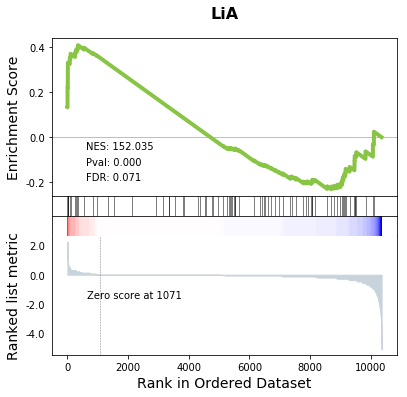

In [64]:
from gseapy.plot import gseaplot, heatmap
terms = pre_res.res2d.index
# Make sure that ``ofname`` is not None, if you want to save your figure to disk
gseaplot(pre_res.ranking, term=terms[4], **pre_res.results[terms[4]])

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import scrublet as scr
import os
import warnings
import functools
import seaborn as sns
import scipy.stats
import anndata
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

warnings.filterwarnings('ignore')
os.chdir(os.path.expanduser('/home/jovyan/Prostate_analysis/scanpy'))
sc.settings.verbosity = 3
sc.logging.print_versions()

results_file = 'out/mnp.integrated.h5ad'

adata = sc.read_h5ad(results_file)
adata

/home/jovyan/my-conda-envs/mypython3/lib/python3.7/site-packages/dask/config.py:161: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


scanpy==1.4.5.post2 anndata==0.6.22.post1 umap==0.3.10 numpy==1.17.2 scipy==1.4.1 pandas==0.25.1 scikit-learn==0.22.1 statsmodels==0.11.0rc1 python-igraph==0.7.1 louvain==0.6.1


AnnData object with n_obs × n_vars = 793 × 3000 
    obs: 'age', 'barcode', 'batch', 'group', 'highest_GLEASON_score', 'mri_grading', 'name', 'patient', 'pool', 'psa', 'sample', 'scrublet_score', 'scrublet_cluster_score', 'bh_pval', 'is_doublet', 'n_genes', 'percent_mito', 'n_counts', 'S_score', 'G2M_score', 'phase', 'leiden', 'celltype', 'cohort', 'nCount_RNA', 'nFeature_RNA', 'nCount_SCT', 'nFeature_SCT', 'celltype-immune'
    var: 'gene_ids', 'feature_types'
    uns: 'celltype-immune_colors', 'cohort_colors', 'dendrogram_celltype-immune', 'dendrogram_leiden', 'group_colors', 'leiden', 'leiden_colors', 'neighbors', 'patient_colors', 'pca', 'phase_colors', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'

In [6]:
### run GSEA Hallmark on Mac-MT1s and compare tumor/normal
def rankList(deg_file, remove_ribo_mito = False):
    # read in the files and do some ranking calculations
    deg = pd.read_csv(deg_file, sep = '\t', index_col = 0)
    if remove_ribo_mito:
        # remove ribosomal and mitochondrial genes
        deg = deg[~deg.index.str.contains('RPS|RPL|MT-')]

    # convert to negative log10 pval
    deg['neglog10pval'] = [-1*np.log10(p) for p in deg['pvals']]
    # convert inf values to max machine number
    try:
        deg['neglog10pval'].replace(np.inf, -1*np.log10(10**-308), inplace = True)
    except:
        pass
    try:    
        deg['neglog10pval'].replace(-np.inf, -1*np.log10(10**308), inplace = True)
    except:
        pass
    deg['rank'] = [p*np.sign(lfc) for p, lfc in zip(deg['neglog10pval'], deg['logfoldchanges'])]
    deg = deg.reset_index(drop = False)
    return(deg[['index', 'rank']])
# quickly prep the files
MacMT1 = rankList('out/DEG/normal celltype markers/full/Mac-MT1_normal.txt', False)
MacMT1tm = rankList('out/DEG/tumor vs normal/full/Mac-MT1_tumor_vs_normal.txt', False)

In [7]:
# run preranked gsea
import gseapy as gp
pre_res = gp.prerank(rnk=MacMT1,
                     gene_sets='dataset/h.all.v7.0.symbols.gmt',
                     processes=10,
                     min_size=0,
                     max_size=1000,
                     permutation_num=1000, # reduce number to speed up testing
                     no_plot=True,
                     verbose=True)
pre_res.res2d.to_csv('out/GSEA/Mac-MT1_hallmark_gsea_normal_pr.txt', sep ='\t')

2020-05-01 20:22:17,443 Parsing data files for GSEA.............................
2020-05-01 20:22:18,726 0000 gene_sets have been filtered out when max_size=1000 and min_size=0
2020-05-01 20:22:18,727 0050 gene_sets used for further statistical testing.....
2020-05-01 20:22:18,728 Start to run GSEA...Might take a while..................
2020-05-01 20:22:32,711 Start to generate gseapy reports, and produce figures...
2020-05-01 20:22:32,734 Congratulations. GSEApy runs successfully................



In [8]:
pre_res = gp.prerank(rnk=MacMT1tm,
                     gene_sets='dataset/h.all.v7.0.symbols.gmt',
                     processes=10,
                     min_size=0,
                     max_size=1000,
                     permutation_num=1000, # reduce number to speed up testing
                     no_plot=True,
                     verbose=True)
pre_res.res2d.to_csv('out/GSEA/Mac-MT1_hallmark_gsea_tumor_vs_normal_pr.txt', sep ='\t')

2020-05-01 20:22:32,750 Parsing data files for GSEA.............................
2020-05-01 20:22:33,831 0000 gene_sets have been filtered out when max_size=1000 and min_size=0
2020-05-01 20:22:33,836 0050 gene_sets used for further statistical testing.....
2020-05-01 20:22:33,836 Start to run GSEA...Might take a while..................
2020-05-01 20:22:38,278 Start to generate gseapy reports, and produce figures...
2020-05-01 20:22:38,295 Congratulations. GSEApy runs successfully................



In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import scrublet as scr
import os
import warnings
import functools
import seaborn as sns
import scipy.stats
import anndata
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

warnings.filterwarnings('ignore')
os.chdir(os.path.expanduser('/home/jovyan/Prostate_analysis/scanpy'))
sc.settings.verbosity = 3
sc.logging.print_versions()

results_file = 'out/mnp.integrated.h5ad'

adata = sc.read_h5ad(results_file)
adata

scanpy==1.4.5.post2 anndata==0.6.22.post1 umap==0.4.6 numpy==1.19.2 scipy==1.5.3 pandas==0.25.3 scikit-learn==0.23.2 statsmodels==0.12.0 python-igraph==0.8.3 louvain==0.7.0


AnnData object with n_obs × n_vars = 793 × 3000 
    obs: 'age', 'barcode', 'batch', 'group', 'highest_GLEASON_score', 'mri_grading', 'name', 'patient', 'pool', 'psa', 'sample', 'scrublet_score', 'scrublet_cluster_score', 'bh_pval', 'is_doublet', 'n_genes', 'percent_mito', 'n_counts', 'S_score', 'G2M_score', 'phase', 'leiden', 'celltype', 'cohort', 'nCount_RNA', 'nFeature_RNA', 'nCount_SCT', 'nFeature_SCT', 'celltype-immune'
    var: 'gene_ids', 'feature_types'
    uns: 'celltype-immune_colors', 'cohort_colors', 'dendrogram_celltype-immune', 'dendrogram_leiden', 'group_colors', 'leiden', 'leiden_colors', 'neighbors', 'patient_colors', 'pca', 'phase_colors', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'

In [2]:
# run GSEA of Mac-MT1 metabolism
def rankList(deg_file, remove_ribo_mito = False):
    # read in the files and do some ranking calculations
    deg = pd.read_csv(deg_file, sep = '\t', index_col = 0)
    if remove_ribo_mito:
        # remove ribosomal and mitochondrial genes
        deg = deg[~deg.index.str.contains('RPS|RPL|MT-')]

    # convert to negative log10 pval
    deg['neglog10pval'] = [-1*np.log10(p) for p in deg['pvals']]
    # convert inf values to max machine number
    try:
        deg['neglog10pval'].replace(np.inf, -1*np.log10(10**-308), inplace = True)
    except:
        pass
    try:    
        deg['neglog10pval'].replace(-np.inf, -1*np.log10(10**308), inplace = True)
    except:
        pass
    deg['rank'] = [p*np.sign(lfc) for p, lfc in zip(deg['neglog10pval'], deg['logfoldchanges'])]
    deg = deg.reset_index(drop = False)
    return(deg[['index', 'rank']])

In [7]:
# quickly prep the files
macmt1n = rankList('out/DEG/normal celltype markers/full/Mac-MT1_normal.txt', True)
mac1n = rankList('out/DEG/normal celltype markers/full/Mac1_normal.txt', True)
mac2n = rankList('out/DEG/normal celltype markers/full/Mac2_normal.txt', True)
monon = rankList('out/DEG/normal celltype markers/full/Mono_normal.txt', True)
dcn = rankList('out/DEG/normal celltype markers/full/DC_normal.txt', True)

In [9]:
import gseapy as gp
pre_res_macmt1 = gp.prerank(rnk=macmt1n, 
                     gene_sets='./dataset/Hallmarks_metabolism_genesets.gmt',
                     processes=10,
                     min_size=0,
                     max_size=1000,
                     permutation_num=1000, # reduce number to speed up testing
                     no_plot=True,
                     verbose=True)
pre_res_mac1 = gp.prerank(rnk=mac1n, 
                     gene_sets='./dataset/Hallmarks_metabolism_genesets.gmt',
                     processes=10,
                     min_size=0,
                     max_size=1000,
                     permutation_num=1000, # reduce number to speed up testing
                     no_plot=True,
                     verbose=True)
pre_res_mac2 = gp.prerank(rnk=mac2n, 
                     gene_sets='./dataset/Hallmarks_metabolism_genesets.gmt',
                     processes=10,
                     min_size=0,
                     max_size=1000,
                     permutation_num=1000, # reduce number to speed up testing
                     no_plot=True,
                     verbose=True)
pre_res_mono = gp.prerank(rnk=monon, 
                     gene_sets='./dataset/Hallmarks_metabolism_genesets.gmt',
                     processes=10,
                     min_size=0,
                     max_size=1000,
                     permutation_num=1000, # reduce number to speed up testing
                     no_plot=True,
                     verbose=True)
pre_res_dc = gp.prerank(rnk=dcn, 
                     gene_sets='./dataset/Hallmarks_metabolism_genesets.gmt',
                     processes=10,
                     min_size=0,
                     max_size=1000,
                     permutation_num=1000, # reduce number to speed up testing
                     no_plot=True,
                     verbose=True)

2020-12-15 16:09:04,664 Parsing data files for GSEA.............................
2020-12-15 16:09:04,763 0000 gene_sets have been filtered out when max_size=1000 and min_size=0
2020-12-15 16:09:04,764 0005 gene_sets used for further statistical testing.....
2020-12-15 16:09:04,764 Start to run GSEA...Might take a while..................
2020-12-15 16:09:07,178 Start to generate gseapy reports, and produce figures...
2020-12-15 16:09:07,225 Congratulations. GSEApy runs successfully................

2020-12-15 16:09:07,233 Parsing data files for GSEA.............................
2020-12-15 16:09:07,350 0000 gene_sets have been filtered out when max_size=1000 and min_size=0
2020-12-15 16:09:07,351 0005 gene_sets used for further statistical testing.....
2020-12-15 16:09:07,351 Start to run GSEA...Might take a while..................
2020-12-15 16:09:09,138 Start to generate gseapy reports, and produce figures...
2020-12-15 16:09:09,145 Congratulations. GSEApy runs successfully............

In [10]:
pre_res_macmt1.res2d.to_csv('out/GSEA/Mac-MT1_normal_hallmarkmetabolism_gsea.txt', sep='\t')
pre_res_mac1.res2d.to_csv('out/GSEA/Mac1_normal_hallmarkmetabolism_gsea.txt', sep='\t')
pre_res_mac2.res2d.to_csv('out/GSEA/Mac2_normal_hallmarkmetabolism_gsea.txt', sep='\t')
pre_res_mono.res2d.to_csv('out/GSEA/Mono_normal_hallmarkmetabolism_gsea.txt', sep='\t')
pre_res_dc.res2d.to_csv('out/GSEA/DC_normal_hallmarkmetabolism_gsea.txt', sep='\t')

In [11]:
metabolism = {'Glycolysis':['PGK1', 'ALDOA', 'ENO1', 'TPI1', 'PFKP', 'ERO1A', 'ALDOB', 'VEGFA', 'MXI1', 'PKM', 'HK2', 'LDHA', 'EXT1', 'SLC25A10', 'GUSB', 'PFKFB1', 'PGAM1', 'PYGB', 'AK4', 'P4HA1', 'PMM2', 'FAM162A', 'SDC1', 'EGLN3', 'PC', 'B4GALT7', 'FBP2', 'IGFBP3', 'CHPF', 'B3GAT3', 'CHST12', 'HS2ST1', 'MPI', 'GNPDA1', 'AKR1A1', 'PPFIA4', 'B3GAT1', 'CHPF2', 'G6PD', 'MDH2', 'CHST6', 'AC010618.1', 'PGAM2', 'CHST1', 'GPC1', 'TSTA3', 'ALG1', 'GFPT1', 'PRPS1', 'GOT1', 'MDH1', 'SLC35A3', 'GALK1', 'EGFR', 'ANGPTL4', 'CITED2', 'PLOD2', 'QSOX1', 'ME2', 'SPAG4', 'P4HA2', 'GAPDHS', 'ENO2', 'GOT2', 'EXT2', 'SLC25A13', 'HMMR', 'PDK3', 'CXCR4', 'GPC4', 'ECD', 'GNE', 'B4GALT2', 'FUT8', 'MIOX', 'VCAN', 'GPC3', 'B3GALT6', 'HSPA5', 'ME1', 'ADORA2B', 'UGP2', 'MIF', 'NANP', 'ZNF292', 'STC2', 'TPST1', 'PGM2', 'GYS1', 'TKTL1', 'TGFA', 'CHST2', 'PHKA2', 'STMN1', 'GALE', 'MET', 'LCT', 'IRS2', 'POLR3K', 'B4GALT1', 'EFNA3', 'LHX9', 'KDELR3', 'TALDO1', 'DPYSL4', 'VLDLR', 'CD44', 'AGL', 'SOX9', 'DDIT4', 'IDUA', 'CASP6', 'GLCE', 'COPB2', 'DSC2', 'HS6ST2', 'CDK1', 'PLOD1', 'SDC2', 'GMPPB', 'PAXIP1', 'NSDHL', 'RARS', 'SLC16A3', 'GLRX', 'SRD5A3', 'SDC3', 'HDLBP', 'COL5A1', 'CLDN9', 'TFF3', 'STC1', 'KIF20A', 'GYS2', 'SLC37A4', 'LHPP', 'SDHC', 'NASP', 'AURKA', 'B3GNT3', 'ISG20', 'LDHC', 'ARPP19', 'CENPA', 'HOMER1', 'BIK', 'CYB5A', 'HAX1', 'COG2', 'IL13RA1', 'AC074143.1', 'CLDN3', 'AGRN', 'CLN6', 'TXN', 'PAM', 'CAPN5', 'PKP2', 'ABCB6', 'DCN', 'GMPPA', 'BPNT1', 'ANG', 'GPR87', 'GAL3ST1', 'ALDH7A1', 'NT5E', 'IDH1', 'PYGL', 'NDUFV3', 'NDST3', 'PPP2CB', 'PSMC4', 'TPBG', 'TGFBI', 'GALK2', 'CTH', 'KIF2A', 'CACNA1H', 'ANKZF1', 'SAP30', 'RBCK1', 'ELF3', 'RPE', 'B4GALT4', 'DEPDC1', 'RRAGD', 'IER3', 'ALDH9A1', 'DLD', 'MERTK', 'GCLC', 'FKBP4', 'SOD1', 'MED24', 'AK3', 'XYLT2', 'ARTN', 'PPIA', 'CHST4'],
'Oxidative phosphorylation':['NDUFS3','UQCRB','NDUFS2','SDHA','UQCRC1','NDUFA9','NDUFS4','NDUFS1','NDUFA2','NDUFS8','SDHB','NNT','ATP5PO','ATP5MC3','NDUFS7','ATP5F1A','NDUFV1','COX5B','UQCRH','NDUFA1','ATP5F1C','ATP5F1B','COX7B','SDHD','CYCS','NDUFA6','NDUFAB1','COX8A','ACO2','ATP5MC1','CYC1','NDUFB6','ATP5F1E','COX5A','UQCRC2','COX6A1','ATP5F1D','COX6C','ATP5PF','NDUFB3','IDH3B','OGDH','NDUFB8','SURF1','COX6B1','NDUFB5','NDUFA4','NDUFB1','COX4I1','COX7C','UQCRFS1','SDHC','ATP6V1F','COX7A2','SUCLG1','NDUFS6','NDUFA7','FH','NDUFV2','OXA1L','NDUFC1','UQCR11','NDUFA5','CS','ATP6V1G1','ATP5PB','HCCS','HADHB','ATP5PD','PDHA1','NDUFA8','DLD','OPA1','SLC25A11','ATP5ME','PDHB','ATP5MF','NDUFB7','IDH2','MTX2','VDAC3','MDH1','ATP5MC2','IMMT','MDH2','SLC25A3','ATP6V1D','VDAC2','ACADM','COX7A2L','TIMM17A','ATP6V1E1','NDUFA3','SLC25A6','IDH3G','ACADVL','ETFA','TIMM9','IDH3A','TIMM8B','ATP6AP1','TIMM13','UQCRQ','ABCB7','VDAC1','ATP5MG','PHB2','DECR1','SUCLA2','GOT2','DLAT','ATP6V1H','NDUFB2','FDX1','HADHA','ATP6V1C1','MAOB','NDUFB4','UQCR10','ETFDH','GPX4','PDHX','MFN2','AIFM1','ACAA2','ETFB','COX11','ECHS1','PMPCA','ATP6V0B','SLC25A5','DLST','COX15','CYB5A','ALAS1','SLC25A4','CPT1A','SLC25A20','MTRR','COX17','CYB5R3','TOMM22','ACAT1','MRPS11','ATP6V0C','PDK4','TIMM10','LDHA','ECI1','MRPL11','FXN','MRPS12','COX10','RHOT1','ACAA1','ACADSB','LDHB','MRPS30','ATP1B1','BDH2','SLC25A12','TIMM50','MRPL34','ISCA1','MRPL35','IDH1','HSPA9','MRPL15','MRPS15','TOMM70','TCIRG1','ISCU','POLR2F','NQO2','NDUFC2','MRPS22','POR','ATP6V0E1','PHYH','MPC1','GPI','AFG3L2','HSD17B10','CASP7','PRDX3','MGST3','HTRA2','BCKDHA','LRPPRC','RETSAT','ECH1','RHOT2','BAX','MTRF1','GLUD1','SUPV3L1','GRPEL1','PDP1','ALDH6A1','OAT'],
'Fatty acid metabolism':['ACAA1','ACAA2','ACADL','ACADM','ACOT8','ACOX1','ACSL1','ALDH3A2','CCDC58','CPT2','CYP4A11','DECR1','ECH1','ECI1','ELOVL5','FABP1','FABP2','HADH','HIBCH','HMGCL','HSD17B11','IDH1','ME1','MGLL','MLYCD','PCBD1','RETSAT','S100A10','SUCLG1','VNN1','EHHADH','ALDH9A1','HADHB','ECHS1','ACADS','CA2','HSD17B10','ALDH1A1','ACADVL','HSD17B4','CA4','ADH1C','ADH7','PTS','MAOA','HAO2','HSD17B7','MCEE','ACAT2','AUH','HPGD','FH','HMGCS2','ALAD','GPD1','ACO2','CBR1','GRHPR','ACOT2','G0S2','MDH2','HSP90AA1','BCKDHB','UROS','YWHAH','LDHA','CRYZ','RDH16','INMT','UGDH','GSTZ1','IDH3B','MDH1','CRAT','ETFDH','CD36','ECI2','SDHD','ACSL5','HSDL2','HMGCS1','SDHC','CD1D','GCDH','GPD2','ALDH3A1','SLC22A5','PDHB','TDO2','FASN','NBN','PSME1','PPARA','NCAPH2','BPHL','ODC1','CA6','DLD','HCCS','EPHX1','DLST','FMO1','AOC3','UROD','CPT1A','KMT5A','UBE2L6','MIF','SUCLG2','CPOX','SMS','CBR3','NTHL1','CIDEA','IDI1','AADAT','REEP6','HSPH1','APEX1','NSDHL','ADIPOR2','ACSL4','ACSS1','ENO3','IDH3G','LGALS1','METAP1','ALDOA','ACSM3','LTC4S','D2HGDH','ADSL','SUCLA2','SDHA','XIST','OSTC','GLUL','CYP4A22','GABARAPL1','AQP7','CYP1A1','PRDX6','ERP29','H2AFZ','GAPDHS','DHCR24','GAD2','PTPRG','IL4I1','TP53INP2','PDHA1','RAP1GDS1','CEL','BLVRA','SERINC1','BMPR1B','RDH11','ENO2']}

In [12]:
for m in metabolism:
    sc.tl.score_genes(adata, metabolism[m], score_name = m+'_score', use_raw = True)

computing score 'Glycolysis_score'
    finished: added
    'Glycolysis_score', score of gene set (adata.obs) (0:00:00)
computing score 'Oxidative phosphorylation_score'
    finished: added
    'Oxidative phosphorylation_score', score of gene set (adata.obs) (0:00:00)
computing score 'Fatty acid metabolism_score'
    finished: added
    'Fatty acid metabolism_score', score of gene set (adata.obs) (0:00:00)


In [42]:
# adata = adata[adata.obs['group'] == 'normal'].copy()

adata = adata[~(adata.obs['celltype-immune'] == 'Mac-cycling')].copy()
adata

AnnData object with n_obs × n_vars = 763 × 3000 
    obs: 'age', 'barcode', 'batch', 'group', 'highest_GLEASON_score', 'mri_grading', 'name', 'patient', 'pool', 'psa', 'sample', 'scrublet_score', 'scrublet_cluster_score', 'bh_pval', 'is_doublet', 'n_genes', 'percent_mito', 'n_counts', 'S_score', 'G2M_score', 'phase', 'leiden', 'celltype', 'cohort', 'nCount_RNA', 'nFeature_RNA', 'nCount_SCT', 'nFeature_SCT', 'celltype-immune', 'Glycolysis_score', 'Oxidative phosphorylation_score', 'Fatty acid metabolism_score'
    var: 'gene_ids', 'feature_types'
    uns: 'celltype-immune_colors', 'cohort_colors', 'dendrogram_celltype-immune', 'dendrogram_leiden', 'group_colors', 'leiden', 'leiden_colors', 'neighbors', 'patient_colors', 'pca', 'phase_colors', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'

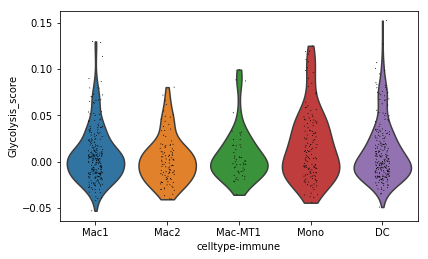

In [43]:
sc.pl.violin(adata, ['Glycolysis_score'], groupby = 'celltype-immune')

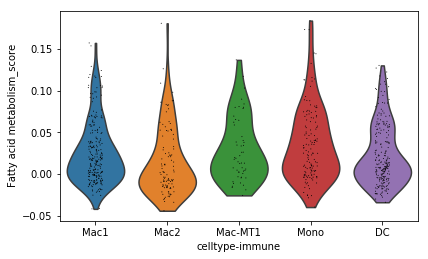

In [44]:
sc.pl.violin(adata, ['Fatty acid metabolism_score'], groupby = 'celltype-immune')

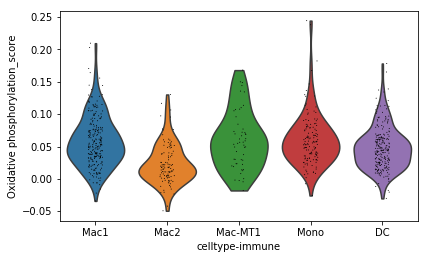

In [45]:
sc.pl.violin(adata, ['Oxidative phosphorylation_score'], groupby = 'celltype-immune')

In [48]:
keep_genes1 = [g for g in metabolism['Glycolysis'] if g in adatax.raw.var.index]

In [54]:
adatatest = sc.AnnData(X = adata.raw.X, var = adata.raw.var, obs = adata.obs)
adatatest

AnnData object with n_obs × n_vars = 763 × 10357 
    obs: 'age', 'barcode', 'batch', 'group', 'highest_GLEASON_score', 'mri_grading', 'name', 'patient', 'pool', 'psa', 'sample', 'scrublet_score', 'scrublet_cluster_score', 'bh_pval', 'is_doublet', 'n_genes', 'percent_mito', 'n_counts', 'S_score', 'G2M_score', 'phase', 'leiden', 'celltype', 'cohort', 'nCount_RNA', 'nFeature_RNA', 'nCount_SCT', 'nFeature_SCT', 'celltype-immune', 'Glycolysis_score', 'Oxidative phosphorylation_score', 'Fatty acid metabolism_score'
    var: 'gene_ids', 'feature_types'

In [58]:
adatatest.var['keep'] = False
adatatest.var.at[keep_genes1, 'keep'] = True

In [70]:
test = adatatest[:, adatatest.var.keep]
test.raw = test

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


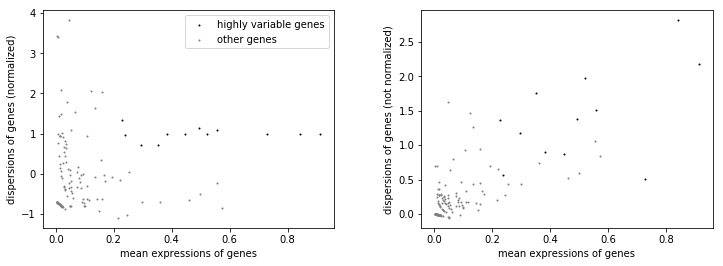

In [71]:
sc.pp.highly_variable_genes(test, min_mean = 0.2, max_mean = 10)
sc.pl.highly_variable_genes(test)

In [72]:
test = test[:, test.var.highly_variable]

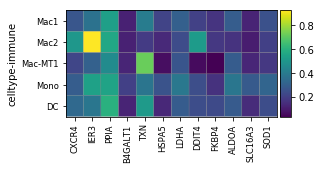

GridSpec(2, 3, height_ratios=[0, 10.5], width_ratios=[3.84, 0, 0.2])

In [73]:
sc.pl.matrixplot(adata, [g for g in test.var.index], groupby = 'celltype-immune')

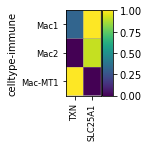

GridSpec(2, 3, height_ratios=[0, 10.5], width_ratios=[0.64, 0, 0.2])

In [40]:
sc.pl.matrixplot(adatax2, ['TXN', 'SLC25A1'], groupby = 'celltype-immune', standard_scale = 'var')